In [3]:
import numpy as np
import matplotlib.pyplot as plt


In [31]:
# Cell with the functions

a1, a2, b1, b2 = 0.1, -0.1, 0.1, -0.12

def explicit_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = x[0] + (b1 - a1*x[1])*x[0]*h + sigma1*x[0]*I[0]
    x_current[1] = x[1] + (b2 - a2*x[0])*x[1]*h + sigma2*x[1]*I[1]   

    return x_current

def patankar_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h + sigma1*x[0]*I[0]) / (1 + a1*x[1]*h)
    x_current[1] = (x[1] + b2*x[1]*h + sigma2*x[1]*I[1]) / (1 + a2*x[0]*h)
    return x_current

def stochastic_patankar_euler_calculation(x, times, h, sigma1, sigma2, I= None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h) / (1 + a1*x[1]*h - sigma1*I[0] + (sigma1*I[0])**2)
    x_current[1] = (x[1] + b2*x[1]*h) / (1 + a2*x[0]*h - sigma2*I[1] + (sigma2*I[1])**2)
    return x_current



############### Methodss ########################################################3

def stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I)

        for j in range(2):
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I)
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I)

        for j in range(2):
            if pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None):

    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]

        eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2, I)
        pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I)
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I)

        for j in range(2):
            if eec[j] > 0:
                x[i, j] = eec[j]
            elif pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x

In [ ]:
# Test to make the simulation
h = 1/(2**12)
times = np.arange(0, 100, h)
x = fully_composite_euler_method(times, h , 0.2, 0.2, [10,10])

plt.plot(times, x[:, 0], label = 'x1')
plt.plot(times, x[:, 1], label = 'x2')
plt.legend()
plt.show()

In [5]:
import numpy as np

def simulate_system(h, sigma1, sigma2, n, initial_cond, total_time):
    # Assuming a regular time grid for simplicity
    times = np.arange(0, total_time, h)
    negative_step_count = 0
    negative_simulation_count = 0
    
    for simulation in range(n):
        x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond)
        # Check for negative values in any simulation
        negative_steps = np.any(x < 0, axis=1)
        negative_step_count += np.sum(negative_steps)
        if np.any(negative_steps):
            negative_simulation_count += 1
    
    average_negative_steps_per_simulation = negative_step_count / n
    return average_negative_steps_per_simulation, negative_simulation_count

# Definitions of the other functions remain unchanged

# Example usage:
h = 1/(2**6)
sigma1 = 0.2
sigma2 = 0.2
n = 100  # Number of simulations
initial_cond = np.array([6, 6])  # Example initial conditions
total_time = 100  # Total time for simulation

average_steps, num_negative_sims = simulate_system(h, sigma1, sigma2, n, initial_cond, total_time)
print(f"Average Negative Steps per Simulation: {average_steps}")
print(f"Number of Simulations with Negative Values: {num_negative_sims}")


Average Negative Steps per Simulation: 0.0
Number of Simulations with Negative Values: 0


In [27]:
def simulate_system(times, h, sigma1, sigma2, initial_cond, I=None, sim = 'fully'):
    steps = len(times)
    
    # Generate shared random values if not provided
    if I is None:
        I = np.random.normal(0, np.sqrt(h), (steps, 2))
    
    if sim == 'fully':
        x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    elif sim == 'composite':
        x = composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    else:
        x = stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I)

    return x, I

In [32]:

a1, a2, b1, b2 = 0.1, -0.1, 0.1, -0.12
sigma1, sigma2 = 0.5, 0.5  

initial_conditions = [10, 10] 

T = 20  
h_fine = 1/(2**19)  
h_coarse = 1/(2**4)  
times_fine = np.arange(0, T, h_fine)
times_coarse = np.arange(0, T, h_coarse)


# Simulate with finer stepsize and save the random values
results_fine, random_values = simulate_system(times_fine, h_fine, sigma1, sigma2, initial_conditions, I = None, sim = 'fully')

random_values_coarse = random_values[::2**15] * np.sqrt(2**15)  
results_coarse, _ = simulate_system(times_coarse, h_coarse, sigma1, sigma2, initial_conditions, random_values_coarse, sim = 'fully')

results_fine, results_coarse


ValueError: setting an array element with a sequence.

In [33]:
# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for x1
axs[0].plot(times_fine, results_fine[:, 0], label=f'Fine Step Size $h = 1/(2^{{19}})$', color='blue')
axs[0].plot(times_coarse, results_coarse[:, 0], label=f'Coarse Step Size $h = 1/(2^{{4}})$', linestyle='--', color='red')
axs[0].set_ylabel('x1')
axs[0].set_title('Stochastic Lotka-Volterra Model Simulation for x1')
axs[0].legend()

# Plot for x2
axs[1].plot(times_fine, results_fine[:, 1], label=f'Fine Step Size $h = 1/(2^{{19}})$', color='blue')
axs[1].plot(times_coarse, results_coarse[:, 1], label=f'Coarse Step Size $h = 1/(2^{{4}})$', linestyle='--', color='red')
axs[1].set_ylabel('x2')
axs[1].set_title('Stochastic Lotka-Volterra Model Simulation for x2')
axs[1].set_xlabel('Time')
axs[1].legend()

plt.tight_layout()
plt.show()


: 

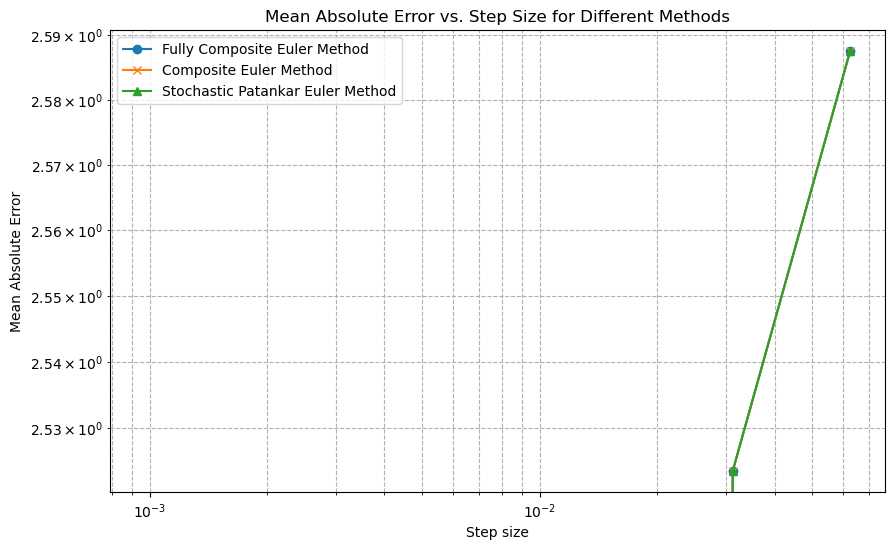

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the stepsizes and initialize the error storage
stepsizes = [1/(2**i) for i in range(10, 3, -1)]  # From 2^-10 to 2^-4
errors_fully_composite = []
errors_composite_euler = []
errors_stoch_patankar = []

# Reference solution from fine stepsize
reference_solution = results_fine  # Results from the fine stepsize 1/(2**12)

def calculate_mae(simulation, reference):
    # Mean Absolute Error calculation
    return np.mean(np.abs(simulation - reference))

# Iterate over each coarser stepsize
for h in stepsizes:
    # Calculate number of steps to match with the reference solution
    step_ratio = int(2**18 / h)
    
    # Adjust random values for current stepsize
    adjusted_random_values = random_values[::step_ratio] * np.sqrt(step_ratio)
    
    # Simulate using your method, passing the necessary parameters including adjusted random values
    results_fully_composite, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'fully')
    errors_fully_composite.append(calculate_mae(results_fully_composite, reference_solution[::step_ratio]))

    results_composite_euler, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'composite')
    errors_composite_euler.append(calculate_mae(results_composite_euler, reference_solution[::step_ratio]))
    
    results_stoch_patankar, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'stoch')
    errors_stoch_patankar.append(calculate_mae(results_stoch_patankar, reference_solution[::step_ratio]))

# Plotting
plt.figure(figsize=(10, 6))
plt.loglog(stepsizes, errors_fully_composite, label='Fully Composite Euler Method', marker='o')
plt.loglog(stepsizes, errors_composite_euler, label='Composite Euler Method', marker='x')
plt.loglog(stepsizes, errors_stoch_patankar, label='Stochastic Patankar Euler Method', marker='^')
plt.xlabel('Step size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Step Size for Different Methods')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


In [18]:
results_composite_euler

array([[10.        , 10.        ],
       [ 6.844903  ,  2.85349111],
       [ 5.15785494,  2.07462286]])

In [29]:
2**18 /2**4

16384.0